# RS-Graph Descriptive Statistics

## Data Loading

In [1]:
import colormaps as cmaps
import matplotlib.pyplot as plt
import opinionated  # noqa
import polars as pl
import seaborn as sns

from rs_graph.db.constants import V2_DATABASE_PATHS

# Set seaborn style
plt.style.use("opinionated_rc")
sns.set_palette(
    cmaps.bold[2:]._colors.tolist(),
)

###############################################################################

DB_URI = f"sqlite:///{V2_DATABASE_PATHS.dev}"

###############################################################################


def read_table(table: str) -> pl.DataFrame:
    return pl.read_database_uri(f"SELECT * FROM {table}", DB_URI)

/Users/evamaxfield/.local/share/mamba/envs/rs-graph/lib/python3.12/site-packages/opinionated/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
docs = read_table("document")
repos = read_table("repository")
pairs = read_table("document_repository_link")
locations = read_table("location")
sources = read_table("source")
institutions = read_table("institution")
researchers = read_table("researcher")
authors = read_table("document_contributor")
author_institutions = read_table("document_contributor_institution")
doc_abstracts = read_table("document_abstract")
repo_readmes = read_table("repository_readme")
repo_contributors = read_table("repository_contributor")
researcher_dev_links = read_table("researcher_developer_account_link")
topics = read_table("topic")
doc_topics = read_table("document_topic")

# Drop to unique doc and unique repo in pairs
pairs = pairs.unique(subset="document_id", keep="none").unique(
    subset="repository_id", keep="none"
)

In [3]:
hydrated_docs = (
    docs.select(
        pl.col("id").alias("document_id"),
        "publication_date",
        "cited_by_count",
        "citation_normalized_percentile",
        "document_type",
        "is_open_access",
        "primary_location_id",
    )
    .join(
        locations.select(
            pl.col("id").alias("primary_location_id"),
            "source_id",
            pl.col("license").alias("primary_location_license"),
        ).join(
            sources.select(
                pl.col("id").alias("source_id"),
                pl.col("name").alias("source_name"),
                pl.col("host_organization_name").alias("source_host_organization"),
                "source_type",
            ),
            on="source_id",
            how="left",
        ),
        on="primary_location_id",
        how="left",
    )
    .join(
        doc_abstracts.select(
            "document_id",
            pl.when(pl.col("content").is_null())
            .then(pl.lit(0))
            .otherwise(pl.col("content").str.len_chars())
            .alias("document_abstract_length_chars"),
            pl.when(pl.col("content").is_null())
            .then(pl.lit(0))
            .otherwise(pl.col("content").str.split(" ").list.len())
            .alias("document_abstract_length_words"),
        ),
        on="document_id",
        how="left",
    )
    .select(
        "document_id",
        "publication_date",
        "cited_by_count",
        "citation_normalized_percentile",
        "document_type",
        "is_open_access",
        "primary_location_license",
        "source_name",
        "source_host_organization",
        "source_type",
        pl.col("document_abstract_length_chars")
        .fill_null(0)
        .alias("document_abstract_length_chars"),
        pl.col("document_abstract_length_words")
        .fill_null(0)
        .alias("document_abstract_length_words"),
    )
)

hydrated_docs

document_id,publication_date,cited_by_count,citation_normalized_percentile,document_type,is_open_access,primary_location_license,source_name,source_host_organization,source_type,document_abstract_length_chars,document_abstract_length_words
i64,date,i64,f64,str,bool,str,str,str,str,u32,u32
1,2015-12-01,43,0.778809,"""article""",true,"""cc-by""","""Genome Medicine""","""BioMed Central""","""journal""",0,0
2,2022-10-01,8,0.803035,"""article""",true,"""cc-by-nc-nd""","""Alcoholism Clinical and Experi…","""Wiley""","""journal""",1957,267
3,2017-12-08,3,0.697165,"""preprint""",true,null,"""bioRxiv (Cold Spring Harbor La…","""Cold Spring Harbor Laboratory""","""repository""",1416,207
4,2020-05-18,1,0.476699,"""preprint""",true,"""cc-by""","""Wellcome Open Research""","""Wellcome""","""journal""",1220,137
5,2017-09-29,2,0.689392,"""preprint""",true,"""public-domain""","""bioRxiv (Cold Spring Harbor La…","""Cold Spring Harbor Laboratory""","""repository""",1289,183
…,…,…,…,…,…,…,…,…,…,…,…
138591,2021-01-01,0,0.0,"""preprint""",true,"""cc-by""","""arXiv (Cornell University)""","""Cornell University""","""repository""",761,112
138592,2020-01-01,0,0.0,"""preprint""",true,"""other-oa""","""arXiv (Cornell University)""","""Cornell University""","""repository""",1094,159
138593,2021-01-01,0,0.0,"""preprint""",true,"""other-oa""","""arXiv (Cornell University)""","""Cornell University""","""repository""",837,127


In [4]:
hydrated_repos = (
    repos.select(
        pl.col("id").alias("repository_id"),
        pl.col("is_fork").alias("repository_is_fork"),
        pl.col("forks_count").alias("repository_forks_count"),
        pl.col("stargazers_count").alias("repository_stargazers_count"),
        pl.col("open_issues_count").alias("repository_open_issues_count"),
        pl.col("commits_count").alias("repository_commits_count"),
        pl.col("size_kb").alias("repository_size_kb"),
        pl.col("topics").alias("repository_topics"),
        pl.col("primary_language").alias("repository_primary_language"),
        pl.col("default_branch").alias("repository_default_branch"),
        pl.col("license").alias("repository_license"),
        pl.col("creation_datetime").alias("repository_creation_datetime"),
        pl.col("last_pushed_datetime").alias("repository_last_pushed_datetime"),
    )
    .join(
        repo_readmes.select(
            pl.col("repository_id"),
            pl.when(pl.col("content").is_null())
            .then(pl.lit(0))
            .otherwise(pl.col("content").str.len_chars())
            .alias("repository_readme_length_chars"),
            pl.when(pl.col("content").is_null())
            .then(pl.lit(0))
            .otherwise(pl.col("content").str.split(" ").list.len())
            .alias("repository_readme_length_words"),
        ),
        on="repository_id",
        how="left",
    )
    .join(
        repo_contributors.group_by("repository_id").agg(
            pl.col("developer_account_id").count().alias("repository_contributors_count"),
        ),
        on="repository_id",
        how="left",
    )
    .with_columns(
        pl.col("repository_readme_length_chars")
        .fill_null(0)
        .alias("repository_readme_length_chars"),
        pl.col("repository_readme_length_words")
        .fill_null(0)
        .alias("repository_readme_length_words"),
        pl.col("repository_contributors_count")
        .fill_null(0)
        .alias("repository_contributors_count"),
    )
    .join(
        researcher_dev_links.filter(
            pl.col("predictive_model_confidence") >= 0.97,
        )
        .sort(
            pl.col("predictive_model_confidence"),
            descending=True,
        )
        .unique(
            subset="researcher_id",
            keep="first",
        )
        .select(
            "researcher_id",
            "developer_account_id",
        )
        .join(
            repo_contributors.select(
                "developer_account_id",
                "repository_id",
            ),
            on="developer_account_id",
            how="left",
        )
        .group_by(
            "repository_id",
        )
        .agg(
            pl.col("researcher_id")
            .unique()
            .count()
            .alias("repository_matched_author_devs_count"),
        ),
        on="repository_id",
        how="left",
    )
    .with_columns(
        pl.col("repository_matched_author_devs_count")
        .fill_null(0)
        .alias("repository_matched_author_devs_count"),
    )
    .with_columns(
        (
            pl.col("repository_matched_author_devs_count")
            / pl.col("repository_contributors_count")
        ).alias("repository_matched_author_devs_pct"),
    )
)

hydrated_repos

repository_id,repository_is_fork,repository_forks_count,repository_stargazers_count,repository_open_issues_count,repository_commits_count,repository_size_kb,repository_topics,repository_primary_language,repository_default_branch,repository_license,repository_creation_datetime,repository_last_pushed_datetime,repository_readme_length_chars,repository_readme_length_words,repository_contributors_count,repository_matched_author_devs_count,repository_matched_author_devs_pct
i64,bool,i64,i64,i64,i64,i64,str,str,str,str,datetime[ns],datetime[ns],u32,u32,u32,u32,f64
1,false,6,17,11,45,5465,null,"""Python""","""master""","""GNU General Public License v3.…",2014-05-05 21:14:57,2018-04-29 16:11:15,3494,383,1,1,1.0
2,false,0,1,0,15,910,null,"""Jupyter Notebook""","""main""","""MIT License""",2021-11-09 04:35:52,2021-11-23 04:14:31,575,72,1,0,0.0
3,false,4,7,1,9,908,null,"""R""","""master""",null,2017-07-10 14:22:18,2018-07-11 12:15:35,13856,2005,1,0,0.0
4,false,0,8,1,129,92494,null,"""Python""","""master""","""MIT License""",2019-04-01 16:16:34,2021-07-12 10:28:10,5848,778,3,2,0.666667
5,false,36,56,21,501,56339,null,"""R""","""master""","""GNU General Public License v3.…",2016-12-13 22:27:50,2024-03-25 19:35:00,10417,1443,8,3,0.375
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
132079,false,48,156,7,25,837,null,"""Lua""","""master""",null,2017-07-26 12:54:04,2019-05-08 23:18:03,8724,1108,3,3,1.0
132080,false,4,16,0,31,127,null,"""Rust""","""main""","""MIT License""",2021-04-27 09:05:06,2022-01-05 21:05:54,6683,1547,4,4,1.0
132081,false,47,236,15,108,10874,null,"""HTML""","""master""","""MIT License""",2020-05-25 19:59:39,2022-06-13 17:34:41,10084,1044,4,6,1.5


In [5]:
hydrated_pairs = (
    pairs.select(
        "document_id",
        "repository_id",
        "dataset_source_id",
    )
    .join(
        hydrated_docs,
        on="document_id",
        how="left",
    )
    .join(
        hydrated_repos,
        on="repository_id",
        how="left",
    )
)

hydrated_pairs

document_id,repository_id,dataset_source_id,publication_date,cited_by_count,citation_normalized_percentile,document_type,is_open_access,primary_location_license,source_name,source_host_organization,source_type,document_abstract_length_chars,document_abstract_length_words,repository_is_fork,repository_forks_count,repository_stargazers_count,repository_open_issues_count,repository_commits_count,repository_size_kb,repository_topics,repository_primary_language,repository_default_branch,repository_license,repository_creation_datetime,repository_last_pushed_datetime,repository_readme_length_chars,repository_readme_length_words,repository_contributors_count,repository_matched_author_devs_count,repository_matched_author_devs_pct
i64,i64,i64,date,i64,f64,str,bool,str,str,str,str,u32,u32,bool,i64,i64,i64,i64,i64,str,str,str,str,datetime[ns],datetime[ns],u32,u32,u32,u32,f64
1,1,1,2015-12-01,43,0.778809,"""article""",true,"""cc-by""","""Genome Medicine""","""BioMed Central""","""journal""",0,0,false,6,17,11,45,5465,null,"""Python""","""master""","""GNU General Public License v3.…",2014-05-05 21:14:57,2018-04-29 16:11:15,3494,383,1,1,1.0
2,2,1,2022-10-01,8,0.803035,"""article""",true,"""cc-by-nc-nd""","""Alcoholism Clinical and Experi…","""Wiley""","""journal""",1957,267,false,0,1,0,15,910,null,"""Jupyter Notebook""","""main""","""MIT License""",2021-11-09 04:35:52,2021-11-23 04:14:31,575,72,1,0,0.0
3,3,1,2017-12-08,3,0.697165,"""preprint""",true,null,"""bioRxiv (Cold Spring Harbor La…","""Cold Spring Harbor Laboratory""","""repository""",1416,207,false,4,7,1,9,908,null,"""R""","""master""",null,2017-07-10 14:22:18,2018-07-11 12:15:35,13856,2005,1,0,0.0
4,4,1,2020-05-18,1,0.476699,"""preprint""",true,"""cc-by""","""Wellcome Open Research""","""Wellcome""","""journal""",1220,137,false,0,8,1,129,92494,null,"""Python""","""master""","""MIT License""",2019-04-01 16:16:34,2021-07-12 10:28:10,5848,778,3,2,0.666667
5,5,1,2017-09-29,2,0.689392,"""preprint""",true,"""public-domain""","""bioRxiv (Cold Spring Harbor La…","""Cold Spring Harbor Laboratory""","""repository""",1289,183,false,36,56,21,501,56339,null,"""R""","""master""","""GNU General Public License v3.…",2016-12-13 22:27:50,2024-03-25 19:35:00,10417,1443,8,3,0.375
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
138590,132078,2,2021-01-01,7,0.892488,"""preprint""",true,"""cc-by""","""arXiv (Cornell University)""","""Cornell University""","""repository""",1327,184,false,7,62,1,17,13992,null,null,"""main""","""MIT License""",2021-02-06 13:04:58,2022-07-20 11:14:06,3681,514,2,1,0.5
138591,132080,2,2021-01-01,0,0.0,"""preprint""",true,"""cc-by""","""arXiv (Cornell University)""","""Cornell University""","""repository""",761,112,false,4,16,0,31,127,null,"""Rust""","""main""","""MIT License""",2021-04-27 09:05:06,2022-01-05 21:05:54,6683,1547,4,4,1.0
138592,132081,2,2020-01-01,0,0.0,"""preprint""",true,"""other-oa""","""arXiv (Cornell University)""","""Cornell University""","""repository""",1094,159,false,47,236,15,108,10874,null,"""HTML""","""master""","""MIT License""",2020-05-25 19:59:39,2022-06-13 17:34:41,10084,1044,4,6,1.5


In [6]:
hydrated_authors = (
    authors.select(
        pl.col("id").alias("document_contributor_id"),
        "researcher_id",
        "document_id",
        pl.col("position").alias("author_position"),
        pl.col("is_corresponding").alias("author_is_corresponding"),
    )
    .join(
        author_institutions.select(
            "document_contributor_id",
            pl.col("institution_id").alias("institution_id"),
        ).join(
            institutions.select(
                pl.col("id").alias("institution_id"),
                pl.col("name").alias("institution_name"),
                pl.col("country_code").alias("institution_country_code"),
                "institution_type",
            ),
            on="institution_id",
            how="left",
        ),
        on="document_contributor_id",
        how="left",
    )
    .join(
        researchers.select(
            pl.col("id").alias("researcher_id"),
            pl.col("works_count").alias("author_works_count"),
            pl.col("cited_by_count").alias("author_cited_by_count"),
            pl.col("h_index").alias("author_h_index"),
        ),
        on="researcher_id",
        how="left",
    )
    .filter(pl.col("document_id").is_in(hydrated_pairs["document_id"].to_list()))
)

hydrated_authors

document_contributor_id,researcher_id,document_id,author_position,author_is_corresponding,institution_id,institution_name,institution_country_code,institution_type,author_works_count,author_cited_by_count,author_h_index
i64,i64,i64,str,bool,i64,str,str,str,i64,i64,i64
1,1,1,"""first""",false,1,"""Computational Physics (United …","""US""","""company""",145,3160,25
1,1,1,"""first""",false,2,"""University of Minnesota""","""US""","""funder""",145,3160,25
2,2,1,"""middle""",false,2,"""University of Minnesota""","""US""","""funder""",165,3079,32
3,3,1,"""middle""",false,1,"""Computational Physics (United …","""US""","""company""",114,2883,28
3,3,1,"""middle""",false,2,"""University of Minnesota""","""US""","""funder""",114,2883,28
…,…,…,…,…,…,…,…,…,…,…,…
677091,136876,138594,"""middle""",false,null,null,null,null,122,1291,17
677092,331784,138594,"""middle""",false,null,null,null,null,3,13,2
677093,152484,138594,"""middle""",false,null,null,null,null,214,840,15


In [7]:
hydrated_doc_topics = (
    doc_topics.select(
        "document_id",
        "topic_id",
        "score",
    )
    .join(
        topics.select(
            pl.col("id").alias("topic_id"),
            pl.col("name").alias("topic_name"),
            pl.col("subfield_name").alias("topic_subfield_name"),
            pl.col("field_name").alias("topic_field_name"),
            pl.col("domain_name").alias("topic_domain_name"),
        ),
        on="topic_id",
        how="left",
    )
    .filter(pl.col("document_id").is_in(hydrated_pairs["document_id"].to_list()))
    .select(
        "document_id",
        "topic_name",
        "topic_subfield_name",
        "topic_field_name",
        "topic_domain_name",
        "score",
    )
)

hydrated_doc_topics

document_id,topic_name,topic_subfield_name,topic_field_name,topic_domain_name,score
i64,str,str,str,str,f64
1,"""Cancer Genomics and Diagnostic…","""Cancer Research""","""Biochemistry, Genetics and Mol…","""Life Sciences""",0.9997
1,"""Genomics and Phylogenetic Stud…","""Molecular Biology""","""Biochemistry, Genetics and Mol…","""Life Sciences""",0.9997
1,"""Genomics and Rare Diseases""","""Genetics""","""Biochemistry, Genetics and Mol…","""Life Sciences""",0.9965
2,"""Alcohol Consumption and Health…","""Pathology and Forensic Medicin…","""Medicine""","""Health Sciences""",0.9966
2,"""Forensic Toxicology and Drug A…","""Toxicology""","""Pharmacology, Toxicology and P…","""Life Sciences""",0.9861
…,…,…,…,…,…
138593,"""Topic Modeling""","""Artificial Intelligence""","""Computer Science""","""Physical Sciences""",0.9952
138593,"""Human Pose and Action Recognit…","""Computer Vision and Pattern Re…","""Computer Science""","""Physical Sciences""",0.9947
138594,"""Advanced Neural Network Applic…","""Computer Vision and Pattern Re…","""Computer Science""","""Physical Sciences""",0.9999


## Univariate

### Domain Counts

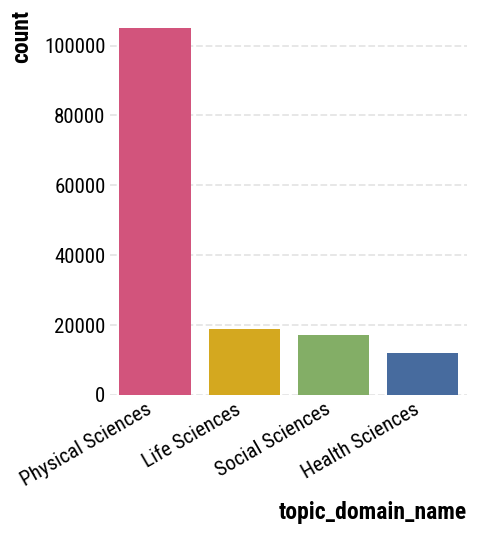

In [8]:
# Drop duplicates on document_id and topic_name
g = sns.catplot(
    hydrated_doc_topics.sort(
        "score",
        descending=True,
    )
    .unique(
        subset=["document_id", "topic_domain_name"],
        keep="first",
    )
    .sort(
        "topic_domain_name",
    )
    .group_by(
        "topic_domain_name",
    )
    .agg(
        pl.col("document_id").count().alias("count"),
    )
    .sort(
        "count",
        descending=True,
    ),
    x="topic_domain_name",
    y="count",
    kind="bar",
    hue="topic_domain_name",
    hue_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
)
g.figure.autofmt_xdate()

### Field Counts

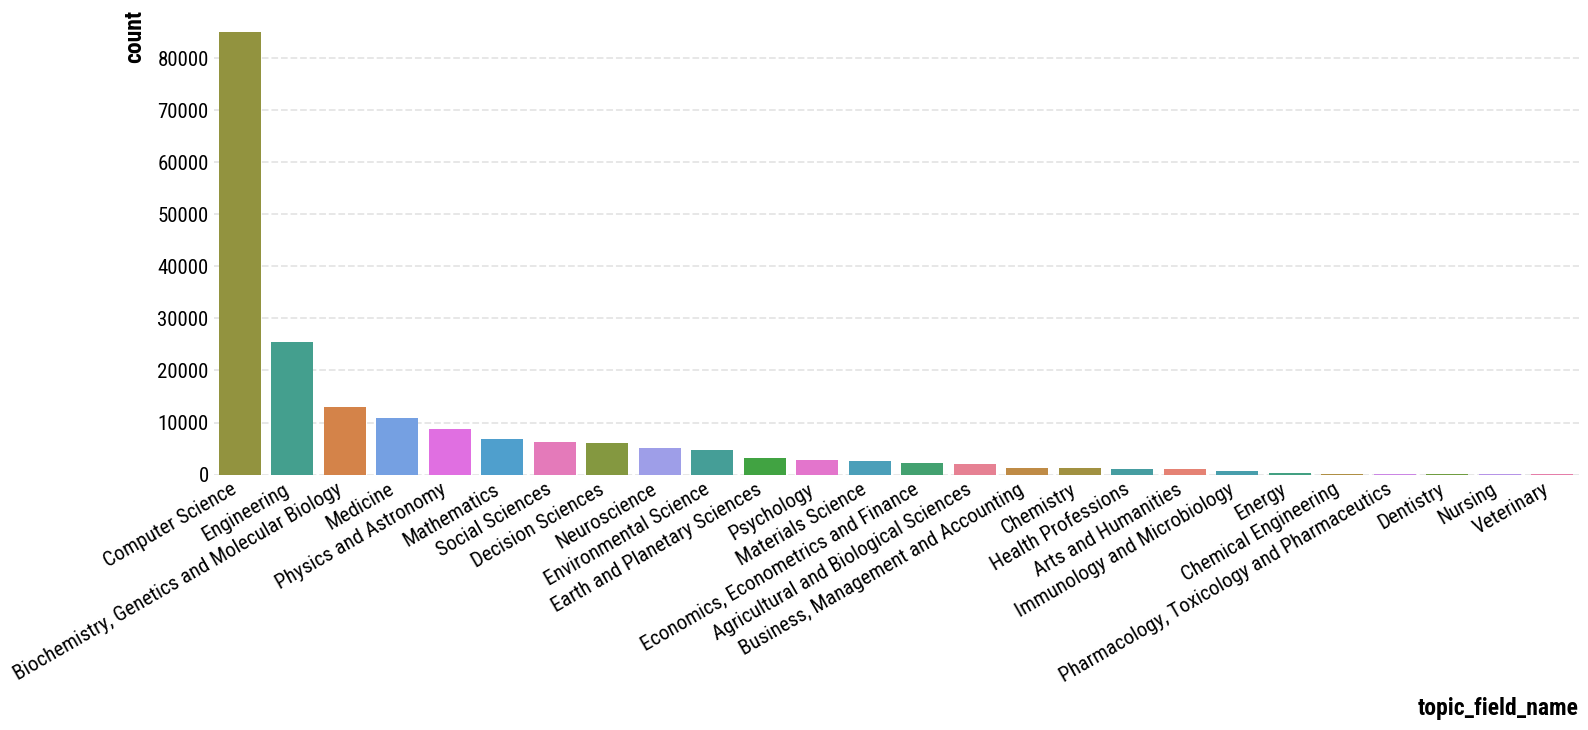

In [9]:
# Drop duplicates on document_id and topic_name
g = sns.catplot(
    hydrated_doc_topics.sort(
        "score",
        descending=True,
    )
    .unique(
        subset=["document_id", "topic_field_name"],
        keep="first",
    )
    .sort(
        "topic_field_name",
    )
    .group_by(
        "topic_field_name",
    )
    .agg(
        pl.col("document_id").count().alias("count"),
    )
    .sort(
        "count",
        descending=True,
    ),
    x="topic_field_name",
    y="count",
    kind="bar",
    hue="topic_field_name",
    hue_order=hydrated_doc_topics["topic_field_name"].unique().sort().to_list(),
    height=6,
    aspect=2.5,
)
g.figure.autofmt_xdate()

### Over Time

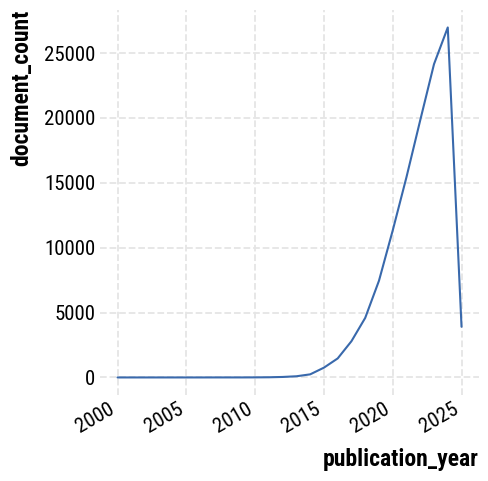

In [10]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_pairs.select(
        "document_id",
        "publication_date",
    )
    .with_columns(pl.col("publication_date").dt.year().alias("publication_year"))
    .group_by(
        "publication_year",
    )
    .agg(
        pl.col("document_id").count().alias("document_count"),
    )
    .sort(
        "publication_year",
    )
    .with_columns(
        pl.col("document_count").cum_sum().alias("document_sum"),
    ),
    x="publication_year",
    y="document_count",
    kind="line",
)
g.figure.autofmt_xdate()

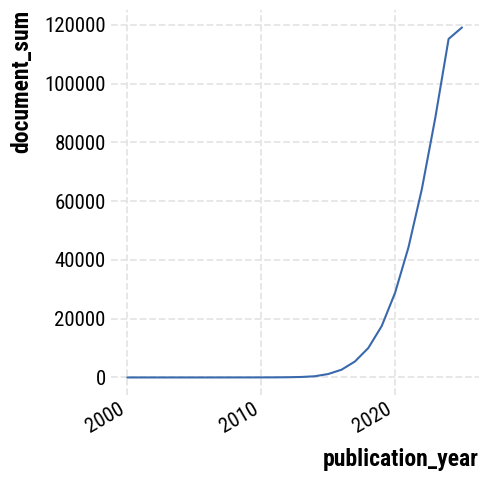

In [11]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_pairs.select(
        "document_id",
        "publication_date",
    )
    .with_columns(pl.col("publication_date").dt.year().alias("publication_year"))
    .group_by(
        "publication_year",
    )
    .agg(
        pl.col("document_id").count().alias("document_count"),
    )
    .sort(
        "publication_year",
    )
    .with_columns(
        pl.col("document_count").cum_sum().alias("document_sum"),
    ),
    x="publication_year",
    y="document_sum",
    kind="line",
)
g.figure.autofmt_xdate()

### Over Time (Repository Created Date)

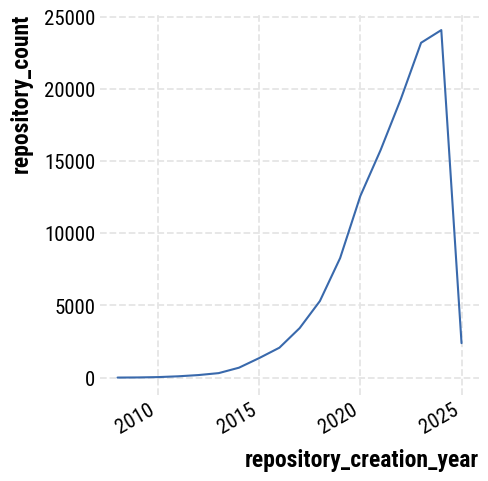

In [12]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_pairs.select(
        "repository_id",
        "repository_creation_datetime",
    )
    .with_columns(
        pl.col("repository_creation_datetime").dt.year().alias("repository_creation_year")
    )
    .group_by(
        "repository_creation_year",
    )
    .agg(
        pl.col("repository_id").count().alias("repository_count"),
    )
    .sort(
        "repository_creation_year",
    )
    .with_columns(
        pl.col("repository_count").cum_sum().alias("repository_sum"),
    ),
    x="repository_creation_year",
    y="repository_count",
    kind="line",
)
g.figure.autofmt_xdate()

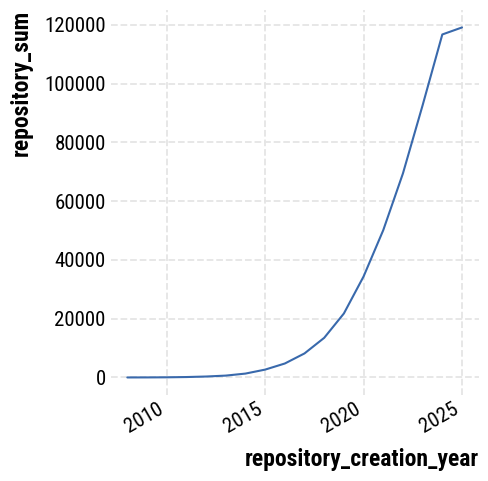

In [13]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_pairs.select(
        "repository_id",
        "repository_creation_datetime",
    )
    .with_columns(
        pl.col("repository_creation_datetime").dt.year().alias("repository_creation_year")
    )
    .group_by(
        "repository_creation_year",
    )
    .agg(
        pl.col("repository_id").count().alias("repository_count"),
    )
    .sort(
        "repository_creation_year",
    )
    .with_columns(
        pl.col("repository_count").cum_sum().alias("repository_sum"),
    ),
    x="repository_creation_year",
    y="repository_sum",
    kind="line",
)
g.figure.autofmt_xdate()

### Article Impact Metrics

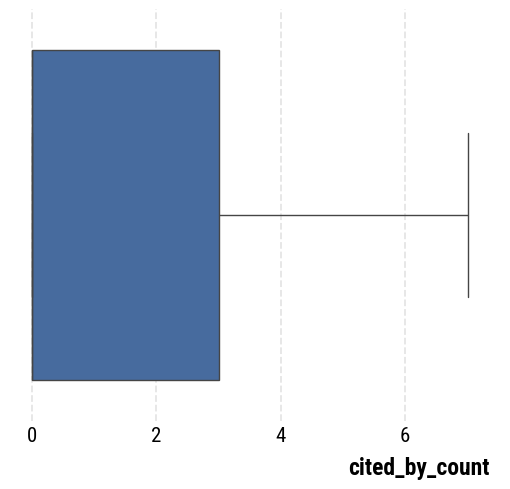

In [14]:
g = sns.catplot(
    hydrated_pairs.select(
        "document_id",
        "cited_by_count",
        "citation_normalized_percentile",
    ),
    x="cited_by_count",
    kind="box",
    showfliers=False,
)

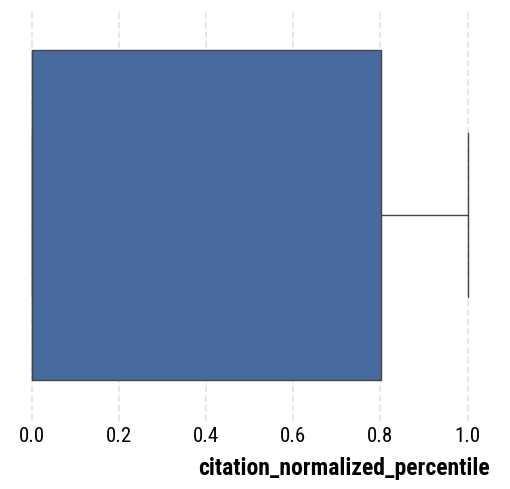

In [15]:
g = sns.catplot(
    hydrated_pairs.select(
        "document_id",
        "cited_by_count",
        "citation_normalized_percentile",
    ),
    x="citation_normalized_percentile",
    kind="box",
    showfliers=False,
)

### Document Type

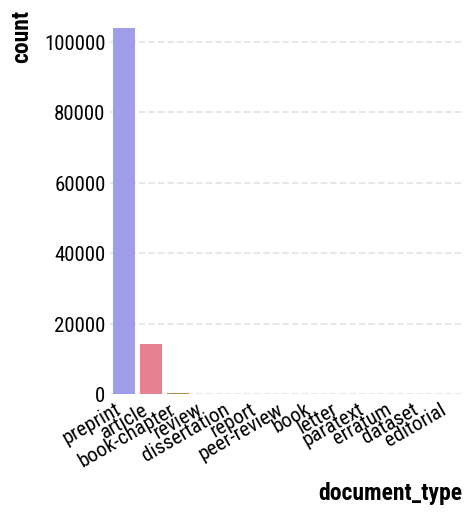

In [16]:
g = sns.catplot(
    hydrated_pairs.select(
        "document_id",
        "document_type",
    )
    .group_by(
        "document_type",
    )
    .agg(
        pl.col("document_id").count().alias("count"),
    )
    .sort(
        "count",
        descending=True,
    ),
    x="document_type",
    y="count",
    kind="bar",
    hue="document_type",
    hue_order=hydrated_docs["document_type"].unique().sort().to_list(),
)
g.figure.autofmt_xdate()

### Source Type

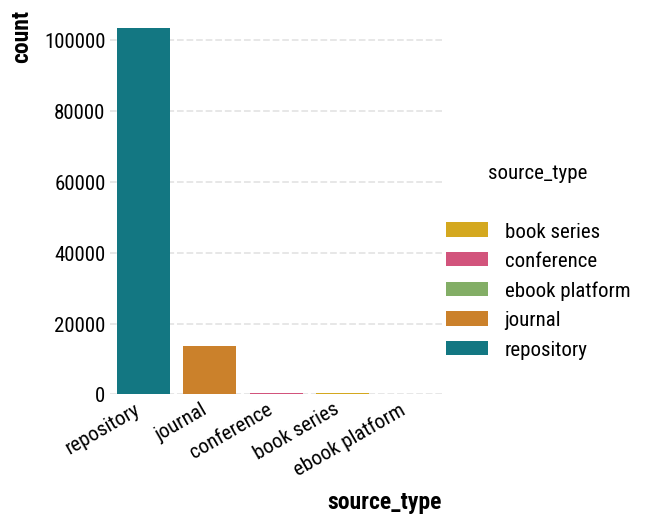

In [17]:
g = sns.catplot(
    hydrated_pairs.select(
        "document_id",
        "source_type",
    )
    .group_by(
        "source_type",
    )
    .agg(
        pl.col("document_id").count().alias("count"),
    )
    .sort(
        "count",
        descending=True,
    ),
    x="source_type",
    y="count",
    kind="bar",
    hue="source_type",
    hue_order=hydrated_docs["source_type"].unique().sort().to_list(),
)
g.figure.autofmt_xdate()

### Location of First Authors

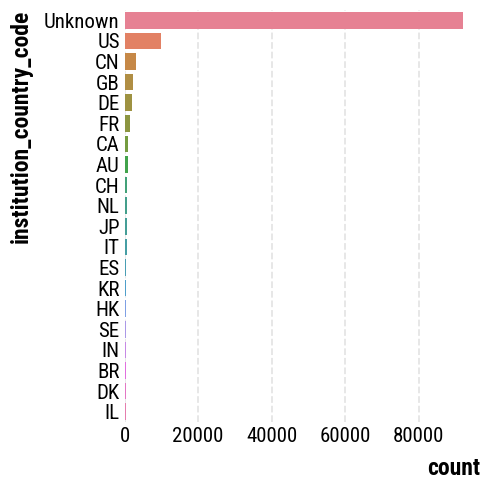

In [18]:
# We want the institution_country_code from hydrated_authors
# hydrated authors has multiple rows per author-document pair due to the fact that a single individual can have multiple affiliations
# So we need to aggregate by document and researcher id and get value counts of institution_country_code
top_locations = (
    hydrated_authors.filter(pl.col("author_position") == "first")
    .select(
        "document_id",
        "researcher_id",
        pl.when(pl.col("institution_country_code").is_null())
        .then(pl.lit("Unknown"))
        .otherwise(pl.col("institution_country_code"))
        .alias("institution_country_code"),
    )
    .group_by(["document_id", "researcher_id"])
    .agg(
        pl.col("institution_country_code").unique(),
    )["institution_country_code"]
    .explode()
    .value_counts(sort=True)[:20]
)

g = sns.catplot(
    data=top_locations,
    x="count",
    y="institution_country_code",
    order=top_locations["institution_country_code"].to_list(),
    hue=top_locations["institution_country_code"].to_list(),
    hue_order=top_locations["institution_country_code"].to_list(),
    kind="bar",
)

### Location of Last Authors

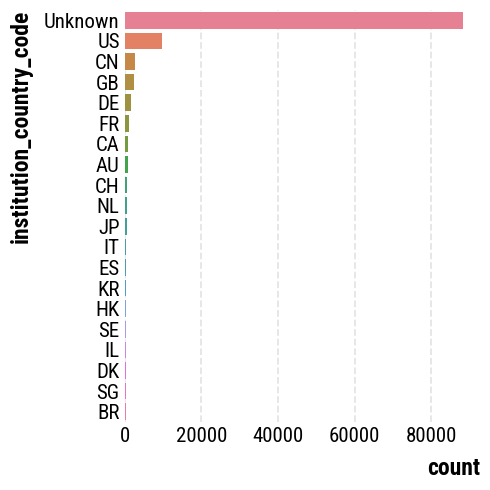

In [19]:
# We want the institution_country_code from hydrated_authors
# hydrated authors has multiple rows per author-document pair due to the fact that a single individual can have multiple affiliations
# So we need to aggregate by document and researcher id and get value counts of institution_country_code
top_locations = (
    hydrated_authors.filter(pl.col("author_position") == "last")
    .select(
        "document_id",
        "researcher_id",
        pl.when(pl.col("institution_country_code").is_null())
        .then(pl.lit("Unknown"))
        .otherwise(pl.col("institution_country_code"))
        .alias("institution_country_code"),
    )
    .group_by(["document_id", "researcher_id"])
    .agg(
        pl.col("institution_country_code").unique(),
    )["institution_country_code"]
    .explode()
    .value_counts(sort=True)[:20]
)

g = sns.catplot(
    data=top_locations,
    x="count",
    y="institution_country_code",
    order=top_locations["institution_country_code"].to_list(),
    hue=top_locations["institution_country_code"].to_list(),
    hue_order=top_locations["institution_country_code"].to_list(),
    kind="bar",
)

### Locations of Corresponding Authors

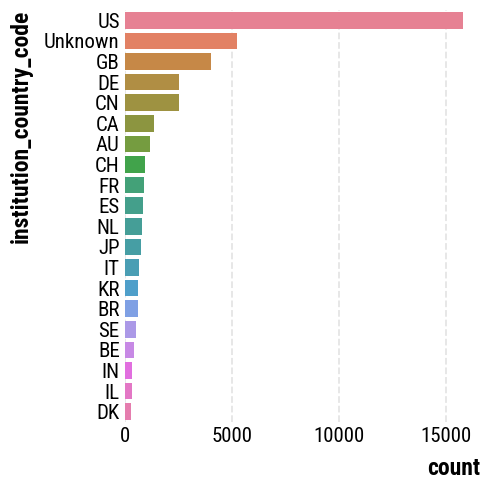

In [20]:
# We want the institution_country_code from hydrated_authors
# hydrated authors has multiple rows per author-document pair due to the fact that a single individual can have multiple affiliations
# So we need to aggregate by document and researcher id and get value counts of institution_country_code
top_locations = (
    hydrated_authors.filter(pl.col("author_is_corresponding"))
    .select(
        "document_id",
        "researcher_id",
        pl.when(pl.col("institution_country_code").is_null())
        .then(pl.lit("Unknown"))
        .otherwise(pl.col("institution_country_code"))
        .alias("institution_country_code"),
    )
    .group_by(["document_id", "researcher_id"])
    .agg(
        pl.col("institution_country_code").unique(),
    )["institution_country_code"]
    .explode()
    .value_counts(sort=True)[:20]
)

g = sns.catplot(
    data=top_locations,
    x="count",
    y="institution_country_code",
    order=top_locations["institution_country_code"].to_list(),
    hue=top_locations["institution_country_code"].to_list(),
    hue_order=top_locations["institution_country_code"].to_list(),
    kind="bar",
)

### Repository Primary Language

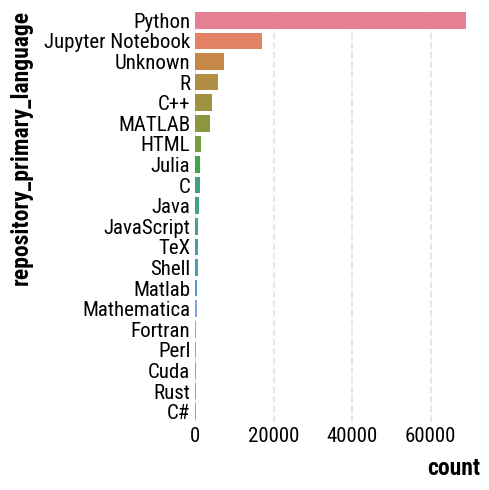

In [21]:
top_repo_langs = hydrated_pairs.select(
    pl.when(pl.col("repository_primary_language").is_null())
    .then(pl.lit("Unknown"))
    .otherwise(pl.col("repository_primary_language"))
    .alias("repository_primary_language"),
)["repository_primary_language"].value_counts(sort=True)[:20]

g = sns.catplot(
    data=top_repo_langs,
    x="count",
    y="repository_primary_language",
    order=top_repo_langs["repository_primary_language"].to_list(),
    hue=top_repo_langs["repository_primary_language"].to_list(),
    hue_order=top_repo_langs["repository_primary_language"].to_list(),
    kind="bar",
)

### Repository Licenses

/Users/evamaxfield/.local/share/mamba/envs/rs-graph/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


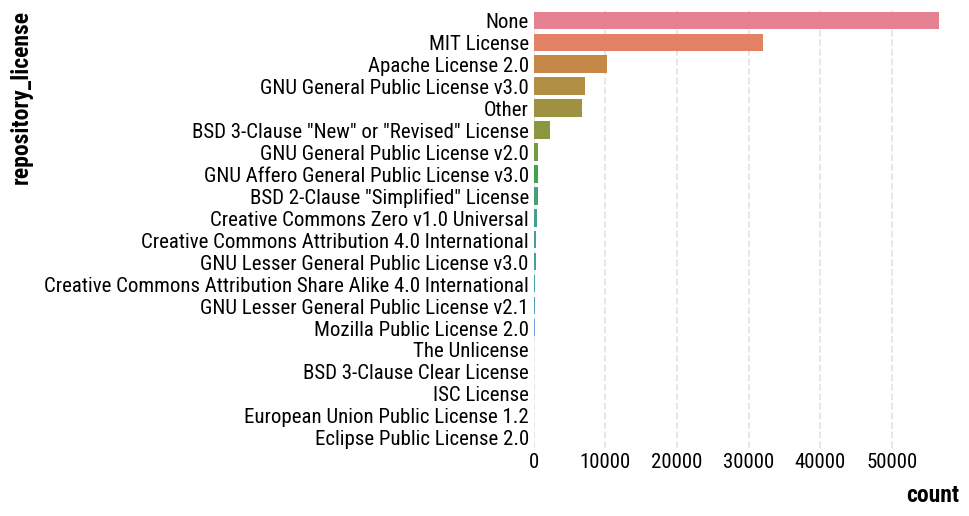

In [22]:
top_repo_licenses = hydrated_pairs.select(
    pl.when(pl.col("repository_license").is_null())
    .then(pl.lit("None"))
    .otherwise(pl.col("repository_license"))
    .alias("repository_license"),
)["repository_license"].value_counts(sort=True)[:20]

g = sns.catplot(
    data=top_repo_licenses,
    x="count",
    y="repository_license",
    order=top_repo_licenses["repository_license"].to_list(),
    hue=top_repo_licenses["repository_license"].to_list(),
    hue_order=top_repo_licenses["repository_license"].to_list(),
    kind="bar",
)

## Domain Breakouts

### Counts over Time

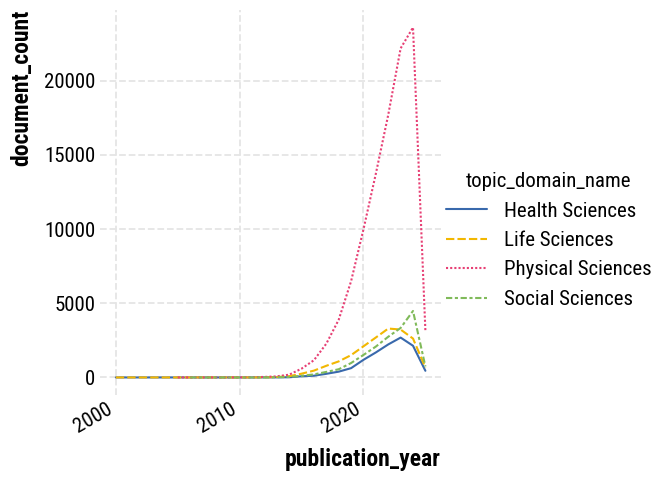

In [23]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_doc_topics.join(
        hydrated_pairs.select(
            "document_id",
            "publication_date",
        ),
        on="document_id",
        how="left",
    )
    .sort(
        "score",
        descending=True,
    )
    .unique(
        subset=["document_id", "topic_domain_name"],
        keep="first",
    )
    .with_columns(pl.col("publication_date").dt.year().alias("publication_year"))
    .group_by(
        "publication_year",
        "topic_domain_name",
    )
    .agg(
        pl.col("document_id").count().alias("document_count"),
    )
    .with_columns(
        pl.col("document_count")
        .cum_sum()
        .over("topic_domain_name", order_by="publication_year")
        .alias("document_sum"),
    ),
    x="publication_year",
    y="document_count",
    hue="topic_domain_name",
    hue_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
    style="topic_domain_name",
    style_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
    kind="line",
)
g.figure.autofmt_xdate()

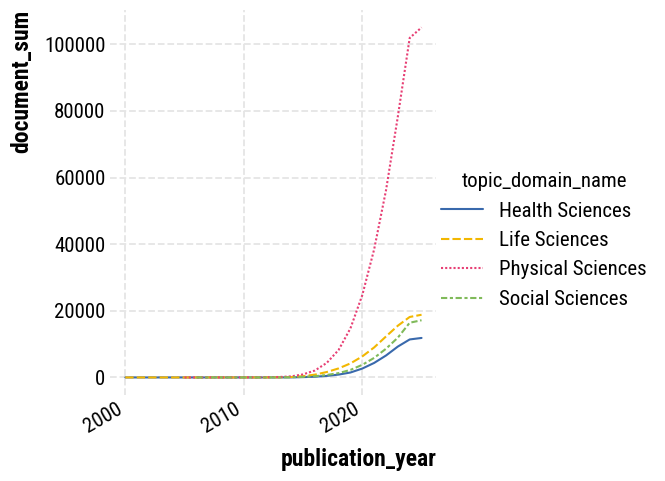

In [24]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_doc_topics.join(
        hydrated_pairs.select(
            "document_id",
            "publication_date",
        ),
        on="document_id",
        how="left",
    )
    .sort(
        "score",
        descending=True,
    )
    .unique(
        subset=["document_id", "topic_domain_name"],
        keep="first",
    )
    .with_columns(pl.col("publication_date").dt.year().alias("publication_year"))
    .group_by(
        "publication_year",
        "topic_domain_name",
    )
    .agg(
        pl.col("document_id").count().alias("document_count"),
    )
    .with_columns(
        pl.col("document_count")
        .cum_sum()
        .over("topic_domain_name", order_by="publication_year")
        .alias("document_sum"),
    ),
    x="publication_year",
    y="document_sum",
    hue="topic_domain_name",
    hue_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
    style="topic_domain_name",
    style_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
    kind="line",
)
g.figure.autofmt_xdate()

### Repository Primary Language

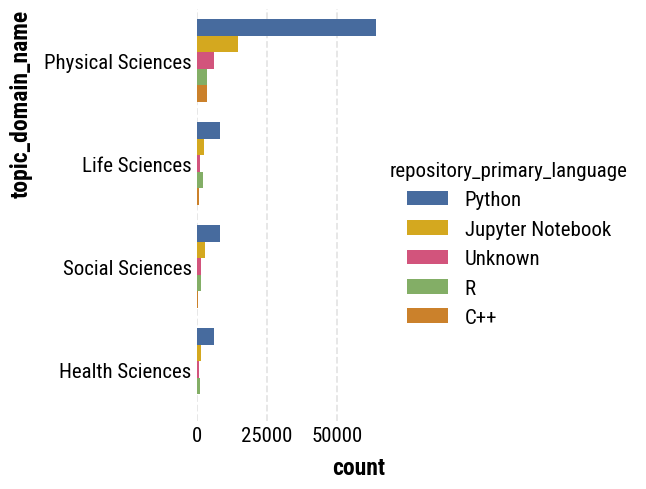

In [25]:
# Find the top 5 repository primary languages
top_repo_langs = (
    hydrated_pairs.select(
        pl.when(pl.col("repository_primary_language").is_null())
        .then(pl.lit("Unknown"))
        .otherwise(pl.col("repository_primary_language"))
        .alias("repository_primary_language"),
    )["repository_primary_language"].value_counts(sort=True)[:5]
)["repository_primary_language"].to_list()

g = sns.catplot(
    data=hydrated_doc_topics.join(
        hydrated_pairs.select(
            "document_id",
            "publication_date",
            pl.when(pl.col("repository_primary_language").is_null())
            .then(pl.lit("Unknown"))
            .otherwise(pl.col("repository_primary_language"))
            .alias("repository_primary_language"),
        ).filter(
            pl.col("repository_primary_language").is_in(top_repo_langs),
        ),
        on="document_id",
        how="left",
    )
    .sort(
        "score",
        descending=True,
    )
    .unique(
        subset=["document_id", "topic_domain_name"],
        keep="first",
    ),
    y="topic_domain_name",
    kind="count",
    hue="repository_primary_language",
    hue_order=top_repo_langs,
)

## Correlation

### Citations by Stars

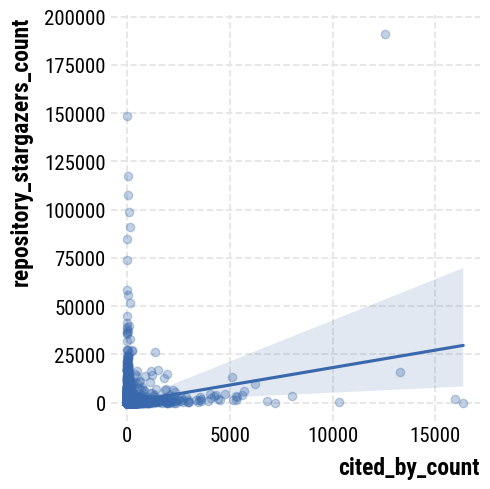

In [26]:
sns.lmplot(
    hydrated_pairs.select(
        "cited_by_count",
        "repository_stargazers_count",
    ),
    x="cited_by_count",
    y="repository_stargazers_count",
    scatter_kws={"alpha": 0.3},
)

### Article License by Repository License

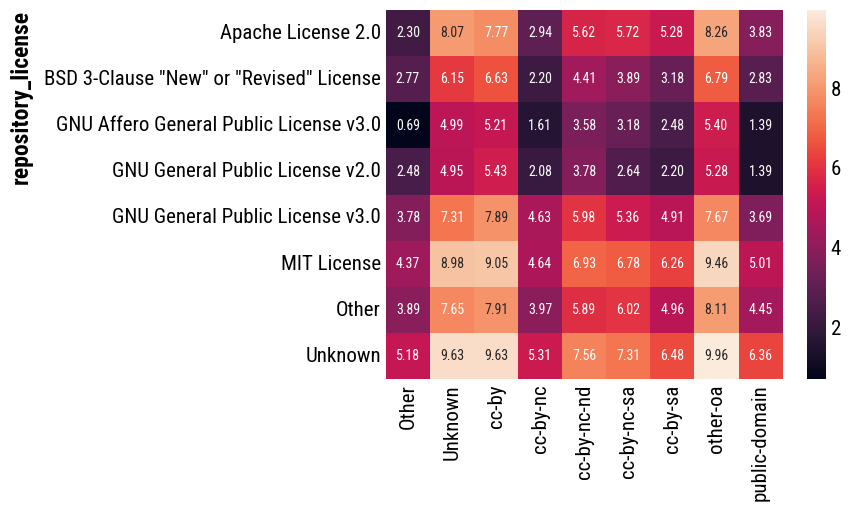

In [27]:
# Find the top 8 most common primary_location_license
top_primary_location_licenses = [
    *hydrated_pairs["primary_location_license"]
    .value_counts(sort=True)[:8]["primary_location_license"]
    .to_list(),
    "Unknown",
]

# Find the top 8 most common repository_license
top_repository_licenses = [
    *hydrated_pairs["repository_license"]
    .value_counts(sort=True)[:8]["repository_license"]
    .to_list(),
    "Unknown",
]

# Select the primary_location_license and repository_license
# but, for null values, replace with "Unknown"
# and replace any values not in the corresponding top lists with "Other"
license_crosstabs = (
    hydrated_pairs.select(
        "document_id",
        pl.when(pl.col("primary_location_license").is_null())
        .then(pl.lit("Unknown"))
        .otherwise(pl.col("primary_location_license"))
        .alias("primary_location_license"),
        pl.when(pl.col("repository_license").is_null())
        .then(pl.lit("Unknown"))
        .otherwise(pl.col("repository_license"))
        .alias("repository_license"),
    )
    .select(
        "document_id",
        pl.when(pl.col("primary_location_license").is_in(top_primary_location_licenses).not_())
        .then(pl.lit("Other"))
        .otherwise(pl.col("primary_location_license"))
        .alias("primary_location_license"),
        pl.when(pl.col("repository_license").is_in(top_repository_licenses).not_())
        .then(pl.lit("Other"))
        .otherwise(pl.col("repository_license"))
        .alias("repository_license"),
    )
    .group_by(["primary_location_license", "repository_license"])
    .agg(pl.col("document_id").count().alias("count"))
    .sort(
        ["repository_license", "primary_location_license"],
    )
    .with_columns(
        # Make log scale
        pl.col("count")
        .log()
        .alias("log_count")
    )
)

# Make heatmap
g = sns.heatmap(
    data=license_crosstabs.pivot(
        on="primary_location_license",
        index="repository_license",
        values="log_count",
    )
    .fill_null(0)
    .to_pandas()
    .set_index(
        "repository_license",
    ),
    annot=True,
    fmt=".2f",
)